In [32]:
import pandas as pd
import numpy as np
import re
import preprocessor as p
import pycld2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
# Custom stop word set that does not include any pronouns and any negating words (e.g. don't, wouldn't)
custom_stopwords = {
    "am", "is", "are", "was", "were", "have", "has", "had", "having",
    "do", "does", "did", "doing", "a", "an", "the", "and", "but",
    "if", "or", "because", "as", "until", "while", "of", "at", "by",
    "for", "with", "about", "against", "between", "into", "through",
    "before", "after", "above", "below", "to", "from", "in", "out",
    "on", "over", "under", "again", "then", "once", "when", "where",
    "why", "how", "all", "any", "both", "more", "most", "other",
    "some", "such", "no", "not", "only", "own", "so", "than", "too", "very"
}

In [30]:
def confusion_matrix(y_test, y_pred, labels):

    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()


In [23]:
def clean_text(text):

    # This effectively removes all special characters
    text = p.clean(text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
#     words = text.split()

#     # remove leading and trailing white spaces with strip()
#     # remove custom stopwords from text
#     words = [word.strip() for word in words if word.strip() not in custom_stopwords]
#     text = ' '.join(words)

    # Replace multiple consecutive white spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

In [34]:
def preprocess_data(df):

    # Check for missing values
    missing_values = df.isna().sum()
    print(f'Missing Values:\n{missing_values}\n')

    # Find all tweets that are less than 3 words and remove them
    df['tweet_length'] = [len(text.split()) for text in df.tweet_text]
    df = df.loc[df['tweet_length'] >= 3]
    df.drop('tweet_length', axis=1, inplace=True)

    # Clean the text by removing special characters and converting all text to lower case
    df['tweet_text'] = df['tweet_text'].apply(clean_text)

    return df

In [26]:
def sample(df):

    df = df.loc[df['tweet_text'].apply(lambda x: safe_detect(x) == 'en')]
    
    # Data balancing 
    # Sample 6,305 observation for each category if stop words are removed
    # Sample 6,644 observation for each category if stop words are not removed
    sample_religion = df.loc[df['cyberbullying_type']=='religion'].sample\
        (n=6644, random_state=42)

    sample_age = df.loc[df['cyberbullying_type']=='age'].sample\
        (n=6644, random_state=42)

    sample_other_cyberbullying = df.loc[df['cyberbullying_type']=='other_cyberbullying'].sample\
        (n=6644, random_state=42)

    sample_ethnicity = df.loc[df['cyberbullying_type']=='ethnicity'].sample\
        (n=6644, random_state=42)

    sample_gender = df.loc[df['cyberbullying_type']=='gender'].sample\
        (n=6644, random_state=42)
    
    # Take all not_cyberbullying observations
    not_cyberbullying = df.loc[df['cyberbullying_type']=='not_cyberbullying']
    
    samples_df = pd.concat([sample_religion,sample_age,
                            sample_other_cyberbullying,sample_ethnicity,sample_gender,not_cyberbullying])

    return samples_df

In [6]:
def safe_detect(text):
    try:
        return pycld2.detect(text)[2][0][1]
    except Exception:
        return 'unknown'

In [13]:
def parameter_optimization(X_train, y_train):
    param_dist = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf']}
    random_search = RandomizedSearchCV(svm.SVC(),
        param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
    random_search.fit(X_train, y_train)
    return random_search.best_params_

Check raw cyberbullying tweet data:                                           tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64

Check cleaned cyberbullying tweet data:                                           tweet_text cyberbullying_type
0          in other words your food was crapilicious  not_cyberbullying
1                                    why is so white  not_cyberbullying
2         a classy whore or more red velvet cupcakes  not_cyberbullying
3  meh thanks for the heads up but not too concer...  not_cyberbullying
4  this is an isis account pretending to be a kur... 

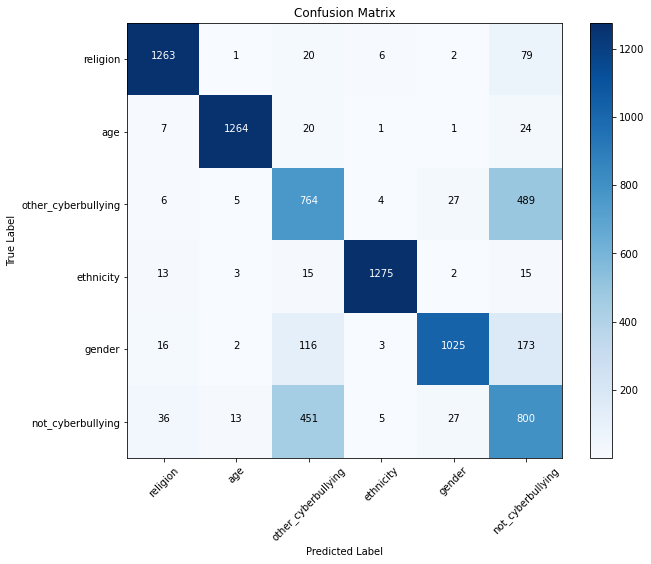

In [35]:
def main():

    df = pd.read_csv("cyberbullying_tweets.csv")
    # Check raw cyberbullying tweet data
    print(f'Check raw cyberbullying tweet data: {df.head(5)}\n')

    df = preprocess_data(df)
    # Check cleaned cyberbullying tweet data
    print(f'Check cleaned cyberbullying tweet data: {df.head(5)}\n')

    # Balance data categories
    df = sample(df)
    
    # Check Unique y values
    y_values = df['cyberbullying_type'].value_counts()
    
    for category, count in y_values.items():
        print(f'Y value: {category}, Count: {count}')
        
    # X is the features (the input data)
    X = df['tweet_text']

    # y is the targets (output or label)
    y = df['cyberbullying_type']

    # Create features based frequency of individual words in a given
    # observation
    ngram_vectorizer = CountVectorizer(ngram_range=(1,2))

    X = ngram_vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, test_size=0.2,
                                                        random_state=42)

    # Perform parameter optimization
#     best_parameters = parameter_optimization(X_train, y_train)
#     print(f'Best parameters: {best_parameters}')
#     SVM = svm.SVC(**best_parameters)
    
    # Best is 80.1% with radial kernel, C=1, gamma='scale'
    SVM = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

    SVM.fit(X_train, y_train)
    y_pred = SVM.predict(X_test)

    print("Training Complete")
    print(f'Accuracy: ', metrics.accuracy_score(y_test, y_pred))

    # Print confusion matrix
    confusion_matrix(y_test, y_pred, labels=df['cyberbullying_type'].unique())

# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()